In [1]:
## Technologies
# CUDA toolkit 10.0
# Tensorflow-gpu 2.0
# cuDNN 7.6.4

In [17]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import tensorflow as tf
from math import ceil
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
#map betweem image names and labels 
matData = loadmat('./cars_annos.mat')

labelsList = []
for arr in matData['annotations'][0]:
    imgPath = arr[0][0]
    labelNum = arr[5][0][0]
    splitTag = arr[6][0][0]
    labelsList.append([imgPath, labelNum, splitTag])
print("img nummber: ", len(labelsList))

labelNameDict = {}
labelList = []
for i,arr in enumerate(matData['class_names'][0]):
    labelName = arr[0]
    labelNameDict[i+1] = labelName
    labelList.append(labelName)
print("label number: ", len(labelNameDict))

labelsDF = pd.DataFrame(labelsList, columns=['imgPath', 'label', 'testTag'])
labelsDF['label'] = labelsDF['label'].map(labelNameDict)
labelsDF.tail(10)

img nummber:  16185
label number:  196


,imgPath,label,testTag
16175,car_ims/016176.jpg,smart fortwo Convertible 2012,1
16176,car_ims/016177.jpg,smart fortwo Convertible 2012,1
16177,car_ims/016178.jpg,smart fortwo Convertible 2012,1
16178,car_ims/016179.jpg,smart fortwo Convertible 2012,1
16179,car_ims/016180.jpg,smart fortwo Convertible 2012,1
16180,car_ims/016181.jpg,smart fortwo Convertible 2012,1
16181,car_ims/016182.jpg,smart fortwo Convertible 2012,1
16182,car_ims/016183.jpg,smart fortwo Convertible 2012,1
16183,car_ims/016184.jpg,smart fortwo Convertible 2012,1
16184,car_ims/016185.jpg,smart fortwo Convertible 2012,1


In [5]:
#test dataform
testDF = labelsDF[labelsDF['testTag']==1]
print("amount of test set:", len(testDF))

amount of test set: 8041


In [6]:
# load best model
model = tf.keras.models.load_model('models/car.75-0.56.hdf5')

In [7]:
#data preprocess parms
img_width, img_height = 224, 224
batch_size = 10

In [8]:
#test data preprocess
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    testDF,
    target_size = (img_width, img_height),
    x_col = 'imgPath',
    y_col = 'label',
    classes = labelList,
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'categorical'
)

Found 8041 validated image filenames belonging to 196 classes.


In [9]:
# test data evaluation
testEvaluation = model.evaluate_generator(
    test_generator,
    verbose = 1
)

805/805 [==============================] - 127s 157ms/step - loss: 2.4095 - acc: 0.5358


In [10]:
# test data predict
testPredict = model.predict_generator(
    test_generator,
    verbose = 1
)

805/805 [==============================] - 86s 107ms/step


In [11]:
# convert predict data to labels
testPredictIndices = np.argmax(testPredict, axis=1)
resultDF = testDF.drop(['testTag'], axis=1)
resultDF['predict'] = testPredictIndices
# label directory starts with 1
resultDF['predict'] += 1
resultDF['predict'] = resultDF['predict'].map(labelNameDict)
resultDF['right'] = np.where(resultDF['predict'] == resultDF['label'], True, False)
resultDF

,imgPath,label,predict,right
45,car_ims/000046.jpg,AM General Hummer SUV 2000,smart fortwo Convertible 2012,False
46,car_ims/000047.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000,True
47,car_ims/000048.jpg,AM General Hummer SUV 2000,HUMMER H2 SUT Crew Cab 2009,False
48,car_ims/000049.jpg,AM General Hummer SUV 2000,AM General Hummer SUV 2000,True
49,car_ims/000050.jpg,AM General Hummer SUV 2000,Geo Metro Convertible 1993,False
...,...,...,...,...
16180,car_ims/016181.jpg,smart fortwo Convertible 2012,smart fortwo Convertible 2012,True
16181,car_ims/016182.jpg,smart fortwo Convertible 2012,smart fortwo Convertible 2012,True
16182,car_ims/016183.jpg,smart fortwo Convertible 2012,smart fortwo Convertible 2012,True
16183,car_ims/016184.jpg,smart fortwo Convertible 2012,Suzuki SX4 Hatchback 2012,False


In [21]:
# show img function
def showImg(imgPath):
    img = Image.open(imgPath)
    plt.figure()
    plt.imshow(img)

Text(0.5, 1.0, 'right predict: Porsche Panamera Sedan 2012')

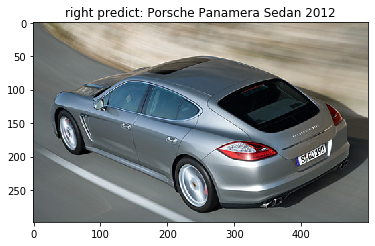

In [35]:
# A predict right image
one_right_img = resultDF[resultDF['right'] == True].sample(1)
showImg(one_right_img['imgPath'].values[0])
plt.title('right predict: ' + one_right_img['label'].values[0])

Text(0.5, 1.0, 'One image example for Audi TTS Coupe 2012')

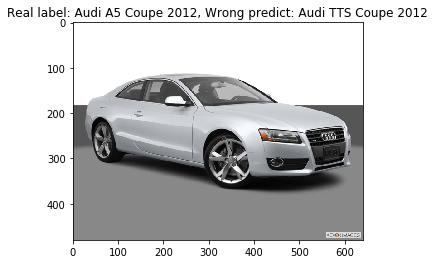

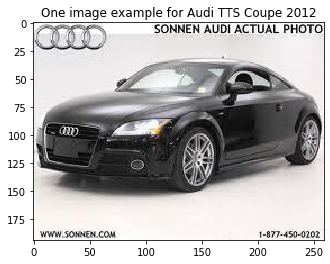

In [126]:
# A predict wrong image
one_wrong_img = resultDF[resultDF['right'] == False].sample(1)
showImg(one_wrong_img['imgPath'].values[0])
plt.title('Real label: ' + one_wrong_img['label'].values[0] + ', Wrong predict: ' + one_wrong_img['predict'].values[0])
true_label_img = resultDF[resultDF['label'] == one_wrong_img['predict'].values[0]].sample(1)
showImg(true_label_img['imgPath'].values[0])
plt.title('One image example for ' + one_wrong_img['predict'].values[0])

In [118]:
# each class's accuracy
classAccDF = resultDF.groupby('label').mean()
classAccDF

,right
label,
AM General Hummer SUV 2000,0.272727
Acura Integra Type R 2001,0.000000
Acura RL Sedan 2012,0.000000
Acura TL Sedan 2012,0.000000
Acura TL Type-S 2008,0.023810
...,...
Volkswagen Golf Hatchback 2012,0.116279
Volvo 240 Sedan 1993,0.000000
Volvo C30 Hatchback 2012,0.000000


In [13]:
# top 10 accuracy classse
top10DF = classAccDF.sort_values(by=['right'],ascending=False).head(10)
top10DF

,right
label,
Suzuki SX4 Hatchback 2012,0.928571
Cadillac CTS-V Sedan 2012,0.837209
Dodge Caravan Minivan 1997,0.813953
Volkswagen Golf Hatchback 1991,0.760870
smart fortwo Convertible 2012,0.750000
Buick Rainier SUV 2007,0.738095
Plymouth Neon Coupe 1999,0.727273
Geo Metro Convertible 1993,0.727273
Volvo XC90 SUV 2007,0.720930


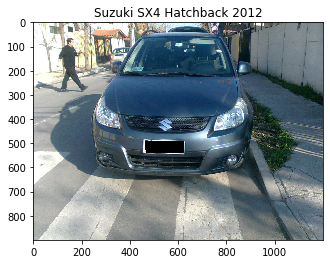

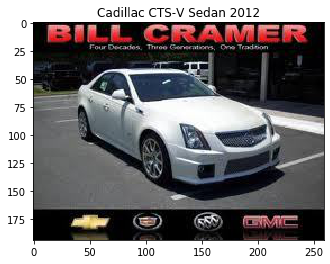

In [70]:
# top 2 acc image
for i in [0,1]:
    item = top10DF.iloc[i,:]
    one_example_img = resultDF[resultDF['label'] == item.name].sample(1)
    showImg(one_example_img['imgPath'].values[0])
    plt.title(item.name)

In [73]:
# last 10 accuracy classes
last10DF = classAccDF.sort_values(by=['right'],ascending=False).tail(10)
last10DF

,right
label,
Chrysler Sebring Convertible 2010,0.0
Dodge Challenger SRT8 2011,0.0
Dodge Ram Pickup 3500 Crew Cab 2010,0.0
Dodge Charger SRT-8 2009,0.0
Dodge Charger Sedan 2012,0.0
Dodge Durango SUV 2007,0.0
Dodge Durango SUV 2012,0.0
Dodge Journey SUV 2012,0.0
Dodge Magnum Wagon 2008,0.0


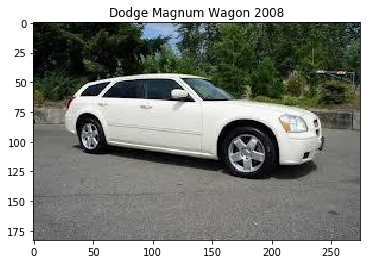

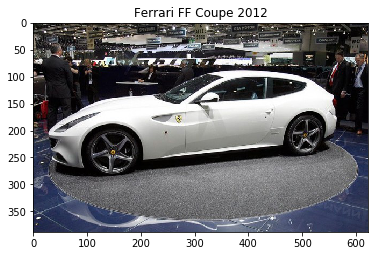

In [75]:
# last 2 acc image
for i in [8,9]:
    item = last10DF.iloc[i,:]
    one_example_img = resultDF[resultDF['label'] == item.name].sample(1)
    showImg(one_example_img['imgPath'].values[0])
    plt.title(item.name)

In [96]:
# top 10 confused data
most_confusedDF = resultDF[resultDF['right'] == False].drop(['right'], axis=1)
most_confusedDF = most_confusedDF.groupby(['label', 'predict']).count()
most_confusedDF = most_confusedDF.sort_values(by=['imgPath'],ascending=False).head(10)
most_confusedDF

,,imgPath
label,predict,
Dodge Durango SUV 2007,Dodge Dakota Club Cab 2007,39
Chrysler PT Cruiser Convertible 2008,Chrysler 300 SRT-8 2010,38
Ford Freestar Minivan 2007,Ford F-150 Regular Cab 2007,37
Ford F-150 Regular Cab 2007,Ford Expedition EL SUV 2009,36
Ford Fiesta Sedan 2012,Ford GT Coupe 2006,36
Chevrolet Avalanche Crew Cab 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,36
Chevrolet Traverse SUV 2012,Chevrolet Silverado 1500 Regular Cab 2012,36
Buick Enclave SUV 2012,Buick Regal GS 2012,35
Ford GT Coupe 2006,Ford Focus Sedan 2007,34


Text(0.5, 1.0, 'Predict class: Dodge Dakota Club Cab 2007')

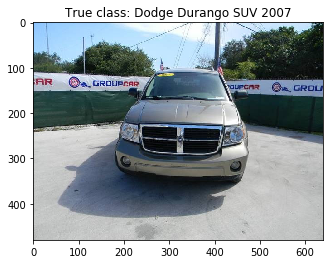

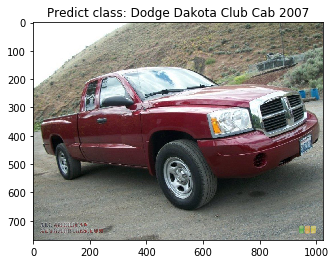

In [109]:
# top 1 confused image
top1_label_img = resultDF[resultDF['label'] == most_confusedDF.index.values[0][0]].sample(1)
showImg(top1_label_img['imgPath'].values[0])
plt.title('True class: ' + top1_label_img['label'].values[0])
top1_predict_img = resultDF[resultDF['label'] == most_confusedDF.index.values[0][1]].sample(1)
showImg(top1_predict_img['imgPath'].values[0])
plt.title('Predict class: ' + top1_predict_img['label'].values[0])